In [5]:
import cPickle
import glob
import gzip
import os
import random
import shutil
import subprocess
import uuid

import cdpybio as cpb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pybedtools as pbt
import seaborn as sns
import statsmodels.api as sm
import vcf as pyvcf

import ciepy as cpy
import projectpy as ppy

%matplotlib inline
%load_ext rpy2.ipython

random.seed(20150605)

In [39]:
sns.set_context('talk')

In [6]:
outdir = os.path.join(cpy.root, 'output',
                      'eqtl_input')
ppy.makedir(outdir)

private_outdir = os.path.join(cpy.root, 'private_output',
                              'eqtl_input')
ppy.makedir(private_outdir)

In [5]:
array_meta = pd.read_table(os.path.join(cpy.root, 'data', 'array_metadata.tsv'), index_col=0)
wgs_meta = pd.read_table(os.path.join(cpy.root, 'data', 'wgs_metadata.tsv'), index_col=0, 
                         squeeze=True)
rna_meta = pd.read_table(os.path.join(cpy.root, 'data', 'rna_seq_metadata.tsv'), index_col=0)

fn = os.path.join(cpy.root, 'private_data', 'TableOf280_PedigreeWithUUIDS_forPhasing_V2.xlsx')
pedigree = pd.read_excel(fn)
pedigree.index = pedigree['ID']

gene_counts = pd.read_table(os.path.join(cpy.root, 'data', 'gene_counts.tsv'),
                            index_col=0)
gene_info = pd.read_table('/raid3/publicdata/gencode_v19/gene_info.tsv',
                          index_col=0)

In [10]:
%%R

suppressPackageStartupMessages(library(DESeq2))
suppressPackageStartupMessages(library("BiocParallel"))
register(MulticoreParam(30))

# Gene Expression

I'll make normalized counts from DESeq and VST counts. I'll also get counts from RSEM.

## Naive Counts: Library Normalized and VST

In [11]:
gene_counts_f = gene_counts[gene_counts.sum(axis=1) > 0]
gene_counts_f = gene_counts_f[gene_counts_f.median(axis=1) > 50]
gene_counts_f = gene_counts_f[gene_info.ix[gene_counts_f.index, 'gene_type'] == 'protein_coding']

In [12]:
tmeta = rna_meta[['subject', 'passage', 'flowcell']]
index = tmeta.index
genes = gene_counts_f.index
counts = gene_counts_f

In [13]:
%%R -i outdir,counts,tmeta,index,genes

rownames(tmeta) = index
rownames(counts) = genes

# make DESeq data set
dds = DESeqDataSetFromMatrix(
    countData = counts, colData = tmeta, 
    design = ~ subject
    )

dds = estimateSizeFactors(dds)

write.table(counts(dds, normalized=TRUE), 
            file=paste(outdir, "norm_counts.tsv", sep="/"),
            quote=FALSE, col.names=NA, sep="\t")

vsd = varianceStabilizingTransformation(dds)

write.table(assay(vsd), 
            file=paste(outdir, "vst_counts.tsv", sep="/"),
            quote=FALSE, col.names=NA, sep="\t")

In [14]:
vsd = pd.read_table(os.path.join(outdir, 'vst_counts.tsv'), index_col=0)

## RSEM

TODO

# Variant Regions

I'm going to identify the regions within 1 megabase of the TSSs for each gene whose
variants I want to test.

In [85]:
fn = os.path.join(outdir, 'variant_regions.bed')
if not os.path.exists(fn):
    variant_regions = cpb.gencode.make_promoter_bed(ppy.gencode_gtf, merge_by_gene=True,
                                                   up=1000000, down=1000000, out=fn)
else:
    variant_regions = pbt.BedTool(fn)

In principle, there could be multiple regions per gene if a gene has TSSs located more than
1MB apart. In practice, this doesn't seem to happen.

In [96]:
gene_to_regions = dict()
for r in variant_regions:
    gene = r.name.split('_')[0]
    gene_to_regions[gene] = gene_to_regions.get(gene, []) + ['{}:{}-{}'.format(
            r.chrom, r.start, r.end)]
fn = os.path.join(outdir, 'gene_to_regions.p')
cPickle.dump(gene_to_regions, open(fn, 'wb') )

# Kinship Matrices

## Arrays

I'll make a kinship matrix using the blood/fibroblast arrays for each person.

In [35]:
array_kmatrix = os.path.join(outdir, 'array.kin')
array_vcf = os.path.join(cpy.root, 'private_data', 'exome_array', 'array_kinship.vcf.gz')

c = ('{} make-kin --vcf {} --min-maf 0.01 --min-callrate 0.95 '
     '--out {} --run 10'.format(ppy.epacts, array_vcf, array_kmatrix))
subprocess.check_call(c, shell=True)

array_kdump = os.path.join(outdir, 'array.kindump')
c = ('{}/pEmmax kin-util --kinf {} --outf {} --dump'.format(
    os.path.split(ppy.epacts)[0], array_kmatrix, os.path.splitext(array_kdump)[0]))
subprocess.check_call(c, shell=True)

0

In [36]:
akmatrix = pd.read_table(array_kdump)

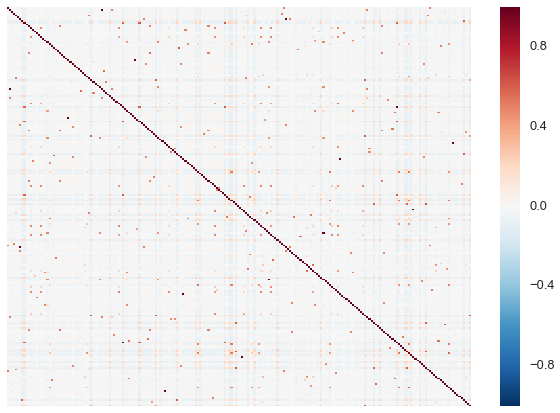

In [40]:
sns.heatmap(akmatrix, xticklabels=False, yticklabels=False, linewidths=0);

# WGS

I'll make a kinship matrix using the WGS data. I'm going to restrict to SNPs on the array.

In [41]:
wgs_kmatrix = os.path.join(outdir, 'wgs.kin')
wgs_vcf = os.path.join(cpy.root, 'private_data', 'wgs', 'kinship', '0000.vcf.gz')

c = ('{} make-kin --vcf {} --min-maf 0.01 --min-callrate 0.95 '
     '--out {} --run 10'.format(ppy.epacts, wgs_vcf, wgs_kmatrix))
subprocess.check_call(c, shell=True)

wgs_kdump = os.path.join(outdir, 'wgs.kindump')
c = ('{}/pEmmax kin-util --kinf {} --outf {} --dump'.format(
    os.path.split(ppy.epacts)[0], wgs_kmatrix, os.path.splitext(wgs_kdump)[0]))
subprocess.check_call(c, shell=True)

0

In [42]:
wgskmatrix = pd.read_table(wgs_kdump)

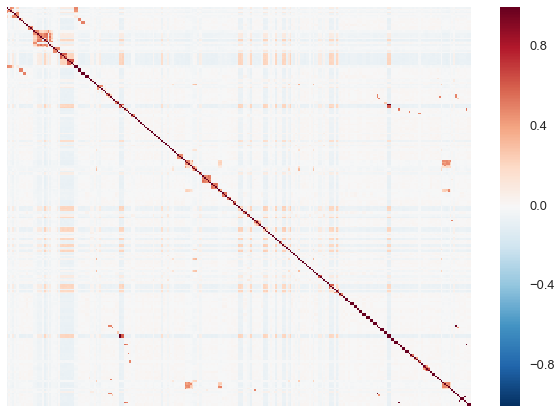

In [43]:
sns.heatmap(wgskmatrix, xticklabels=False, yticklabels=False, linewidths=0);

## Compare Array and WGS Kinship Matrices

I'll convert the indices of the kinship matrix to subject IDs for comparison.

In [ ]:
akmatrix.index = array_meta.ix[akmatrix.index, 'ID_subject'].values
akmatrix.columns = array_meta.ix[akmatrix.columns, 'ID_subject'].values

wgskmatrix.index = wgs_meta.ix[wgskmatrix.index, 'subject'].values
wgskmatrix.columns = wgs_meta.ix[wgskmatrix.columns, 'subject'].values

shared = set(akmatrix.index) & set(wgskmatrix.index)
akmatrix = akmatrix.ix[shared, shared]
wgskmatrix = wgskmatrix.ix[shared, shared]
len(shared)

In [ ]:
sns.clustermap(akmatrix, xticklabels=False, yticklabels=False, linewidths=0);

In [ ]:
sns.clustermap(wgskmatrix, xticklabels=False, yticklabels=False, linewidths=0);

In [ ]:
diff = wgskmatrix - akmatrix
sns.heatmap(diff, xticklabels=False, yticklabels=False, linewidths=0);

In [ ]:
diff.max()